In [1]:
import pandas as pd
import polars as pl
from data import *
import numpy as np
import matplotlib.dates
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import pyarrow
import sklearn
import random
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import sys
import numpy as np
from scipy import stats
from typing import cast
from utils import *
import wrds

In [2]:
full_data = pl.read_csv(get_data_file_path("signed_predictors_all_wide.csv"), schema_overrides=ALL_DATA_ENTRY_SCHEMA)
full_data = full_data.sort(by=["permno", "yyyymm"], maintain_order=True)
full_data = full_data.with_columns(full_data["yyyymm"].str.to_date("%Y%m").alias("date"))
full_data

permno,yyyymm,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,AdExp,AgeIPO,AnalystRevision,AnalystValue,AnnouncementReturn,AssetGrowth,BM,BMdec,BPEBM,Beta,BetaFP,BetaLiquidityPS,BetaTailRisk,BidAskSpread,BookLeverage,BrandInvest,CBOperProf,CF,CPVolSpread,Cash,CashProd,ChAssetTurnover,ChEQ,ChForecastAccrual,ChInv,ChInvIA,ChNAnalyst,ChNNCOA,…,SurpriseRD,Tax,TotalAccruals,TrendFactor,UpRecomm,VarCF,VolMkt,VolSD,VolumeTrend,XFIN,betaVIX,cfp,dCPVolSpread,dNoa,dVolCall,dVolPut,fgr5yrLag,grcapx,grcapx3y,hire,iomom_cust,iomom_supp,realestate,retConglomerate,roaq,sfe,sinAlgo,skew1,std_turn,tang,zerotrade,zerotradeAlt1,zerotradeAlt12,STreversal,Price,Size,date
i64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,date
10000,"""198512""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,null,null,1985-12-01
10000,"""198601""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,-0.005234,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,-1.475907,-9.686575,1986-01-01
10000,"""198602""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,-0.003488,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,4.7852e-8,null,25.7143,-1.178655,-9.389323,1986-02-01
10000,"""198603""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,-0.002715,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1.0234e-7,null,-36.5385,-1.490091,-9.700759,1986-03-01
10000,"""198604""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,0.000877,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,7.4675e-8,null,9.8592,-1.386294,-9.627207,1986-04-01
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
93436,"""202401""",null,null,-0.003877,0.016862,null,null,null,null,null,null,null,null,-0.325232,null,null,null,null,null,null,null,null,-1.838476,null,null,null,null,null,null,0.598015,-1.480804,null,-0.098042,null,null,0.097266,…,0.0,0.288081,-0.223286,null,null,null,null,null,null,0.040382,null,null,null,-0.109511,null,null,null,null,null,-0.251513,null,null,null,null,null,null,null,null,null,0.698178,null,null,null,null,null,null,2024-01-01
93436,"""202402""",null,null,-0.003877,0.016862,null,null,null,null,null,null,null,null,-0.325232,null,null,null,null,null,null,null,null,-1.838476,null,null,null,null,null,null,0.598015,-1.480804,null,-0.098042,null,null,0.097266,…,0.0,0.288081,-0.223286,null,null,null,null,null,null,0.040382,null,null,null,-0.109511,null,null,null,null,null,-0.251513,null,null,null,null,null,null,null,null,null,0.698178,n

In [3]:
def rand_sample[T](values: list[T], /, *, n: int, seed: int = 0):
    random.seed(seed)
    return random.choices(values, k=n)

Standard Deviation: 0.65
Standard Deviation: 0.68
Standard Deviation: 0.34
Standard Deviation: 0.62
Standard Deviation: 1.04
Standard Deviation: 0.28


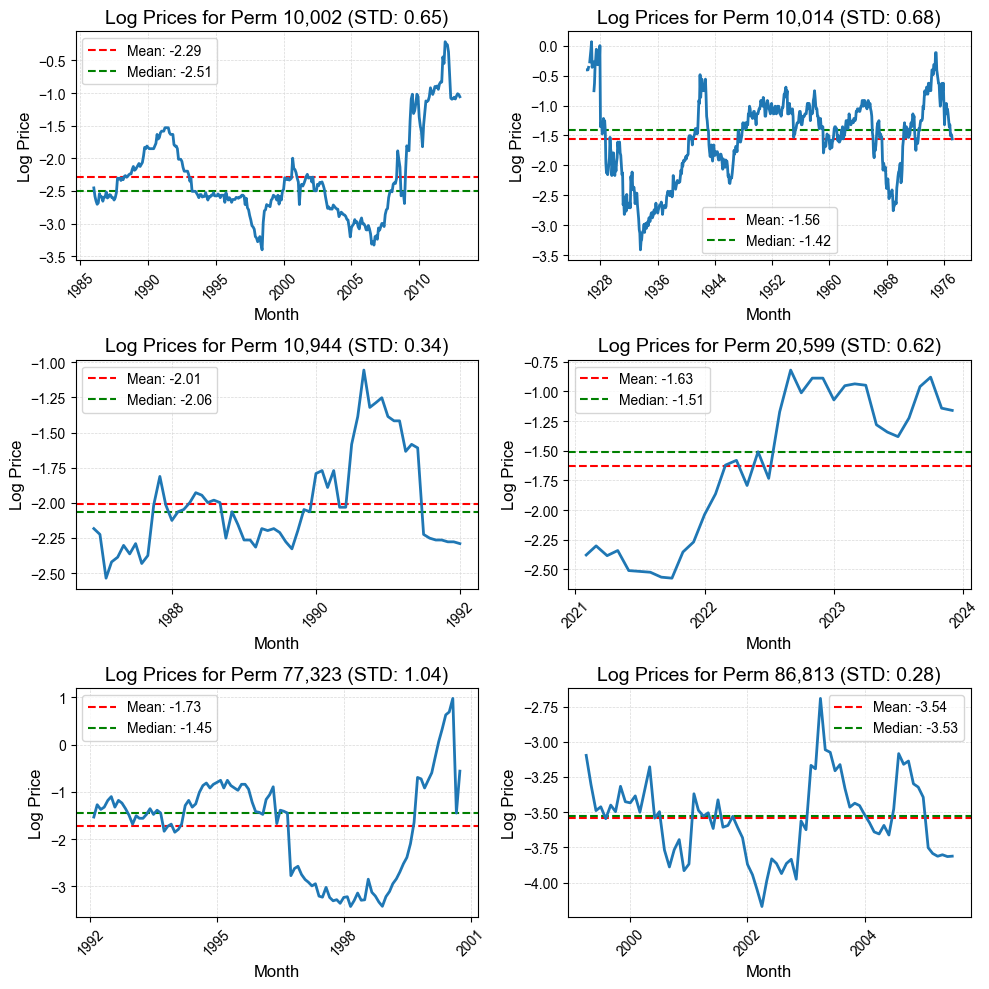

In [78]:
plt.style.use("stata.mplstyle")
subplots = plt.subplots(3, 2, figsize=(10, 10))[1]
subplots = subplots.flatten()
current_plot = 0

def plot_prices_for_permno(permno: int, /, *, year_gap: int = 5):
    global current_plot
    filtered = full_data.filter(pl.col("permno") == permno)
    price_np = filtered["Price"].to_numpy()
    average = cast(float, np.nanmean(price_np))
    median = cast(float, np.nanmedian(price_np))
    std = np.nanstd(price_np)
    plot = subplots[current_plot]
    current_plot += 1
    plot.axhline(y=average, color="r", linestyle="--", label=f"Mean: {average:,.2f}", linewidth=1.5)
    plot.axhline(y=median, color="g", linestyle="--", label=f"Median: {median:,.2f}", linewidth=1.5)
    plot.plot(filtered["date"], filtered["Price"])
    plot.set_title(f"Log Prices for Perm {permno:,} (STD: {std:,.2f})")
    plot.xaxis.set_major_locator(matplotlib.dates.YearLocator(year_gap))
    plot.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y"))
    plot.grid(True)
    plot.tick_params(axis='x', rotation=45)
    plot.set_xlabel("Month")
    plot.set_ylabel("Log Price")
    plot.legend()
    print(f"Standard Deviation: {std:,.2f}")

# Plot some examples
plot_prices_for_permno(10_002)
plot_prices_for_permno(10_014, year_gap=8)
plot_prices_for_permno(10_944, year_gap=2)
plot_prices_for_permno(20_599, year_gap=1)
plot_prices_for_permno(77_323, year_gap=3)
plot_prices_for_permno(86_813, year_gap=2)

# Show
plt.tight_layout()
plt.savefig("prices_example.png", dpi=300)
plt.show()

In [3]:
full_data = full_data.sort(by="date", maintain_order=True)
full_data

permno,yyyymm,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,AdExp,AgeIPO,AnalystRevision,AnalystValue,AnnouncementReturn,AssetGrowth,BM,BMdec,BPEBM,Beta,BetaFP,BetaLiquidityPS,BetaTailRisk,BidAskSpread,BookLeverage,BrandInvest,CBOperProf,CF,CPVolSpread,Cash,CashProd,ChAssetTurnover,ChEQ,ChForecastAccrual,ChInv,ChInvIA,ChNAnalyst,ChNNCOA,…,SurpriseRD,Tax,TotalAccruals,TrendFactor,UpRecomm,VarCF,VolMkt,VolSD,VolumeTrend,XFIN,betaVIX,cfp,dCPVolSpread,dNoa,dVolCall,dVolPut,fgr5yrLag,grcapx,grcapx3y,hire,iomom_cust,iomom_supp,realestate,retConglomerate,roaq,sfe,sinAlgo,skew1,std_turn,tang,zerotrade,zerotradeAlt1,zerotradeAlt12,STreversal,Price,Size,date
i64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,date
10006,"""192512""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,-4.691348,-11.088278,1925-12-01
10014,"""192512""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,null,null,1925-12-01
10022,"""192512""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,-4.025352,-9.323669,1925-12-01
10030,"""192512""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,-5.010635,-10.060491,1925-12-01
10049,"""192512""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,-4.304065,-9.825526,1925-12-01
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
85272,"""202410""",null,null,null,-0.082707,null,null,null,null,null,null,null,null,-0.574621,null,null,null,null,null,null,null,null,-1.298188,null,null,null,null,null,null,-0.792602,-1.482673,null,-0.110388,null,null,-0.055897,…,0.0,null,null,null,null,null,null,null,null,null,null,null,null,-0.216307,null,null,null,null,null,0.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,2024-10-01
88841,"""202410""",null,null,0.046021,0.070207,null,null,null,null,null,null,null,null,0.085084,null,null,null,null,null,null,null,null,-1.26169,null,null,null,null,null,null,0.053662,-1.112958,null,0.0,null,null,-0.076316,…,null,1.1701046,-0.039176,null,null,null,null,null,null,0.135177,null,null,null,0.048669,null,null,null,null,null,0.04735,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,2024-10-01
89986,"""202410""",null,null,0.567842,0.43

In [4]:
grouped_data = full_data.group_by("date").len()
dates = grouped_data["date"].to_list()
lengths = grouped_data["len"].to_list()

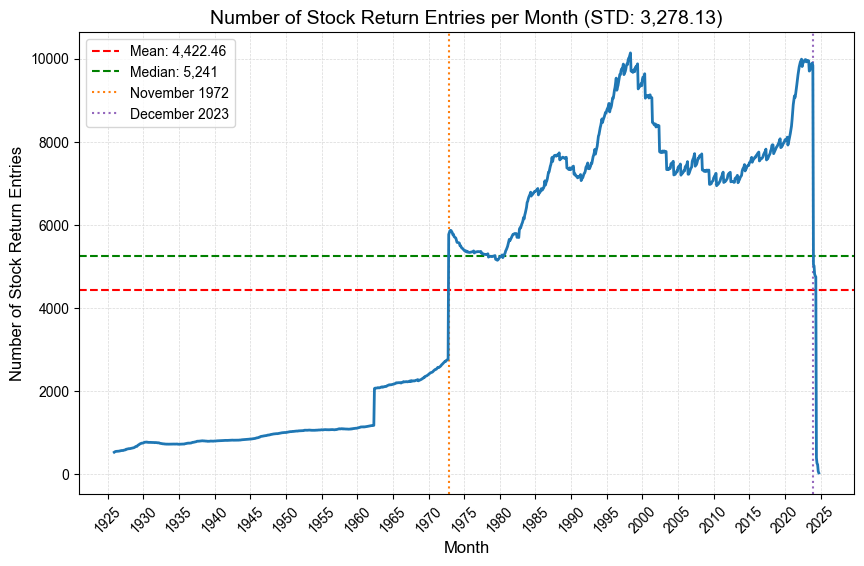

Standard Deviation: 3,278.13


In [35]:
average = cast(float, np.nanmean(lengths))
median = int(cast(float, np.nanmedian(lengths)))
std = np.nanstd(lengths)
plt.style.use("stata.mplstyle")
plt.figure(figsize=(10, 6))
plt.axhline(y=average, color="r", linestyle="--", label=f"Mean: {average:,.2f}", linewidth=1.5)
plt.axhline(y=median, color="g", linestyle="--", label=f"Median: {median:,}", linewidth=1.5)
plt.axvline(x=date(1972, 11, 1), color="tab:orange", linestyle=":", linewidth=1.5, label="November 1972")
plt.axvline(x=date(2023, 12, 1), color="tab:purple", linestyle=":", linewidth=1.5, label="December 2023")
plt.plot(dates, lengths)
plt.title(f"Number of Stock Return Entries per Month (STD: {std:,.2f})")
plt.gca().xaxis.set_major_locator(matplotlib.dates.YearLocator(5))
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y"))
plt.gca().grid(True)
plt.xticks(rotation=45)
plt.xlabel("Month")
plt.ylabel("Number of Stock Return Entries")
plt.legend()
plt.savefig("number_returns_per_month.png", dpi=300)
plt.show()
print(f"Standard Deviation: {std:,.2f}")

In [67]:
full_data.filter(pl.col("date") == date(2023, 12, 1))

permno,yyyymm,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,AdExp,AgeIPO,AnalystRevision,AnalystValue,AnnouncementReturn,AssetGrowth,BM,BMdec,BPEBM,Beta,BetaFP,BetaLiquidityPS,BetaTailRisk,BidAskSpread,BookLeverage,BrandInvest,CBOperProf,CF,CPVolSpread,Cash,CashProd,ChAssetTurnover,ChEQ,ChForecastAccrual,ChInv,ChInvIA,ChNAnalyst,ChNNCOA,…,SurpriseRD,Tax,TotalAccruals,TrendFactor,UpRecomm,VarCF,VolMkt,VolSD,VolumeTrend,XFIN,betaVIX,cfp,dCPVolSpread,dNoa,dVolCall,dVolPut,fgr5yrLag,grcapx,grcapx3y,hire,iomom_cust,iomom_supp,realestate,retConglomerate,roaq,sfe,sinAlgo,skew1,std_turn,tang,zerotrade,zerotradeAlt1,zerotradeAlt12,STreversal,Price,Size,date
i64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,date
10026,"""202312""",null,null,-0.011237,-0.038121,null,null,null,null,null,null,null,null,-0.084428,null,null,null,null,null,null,null,null,-1.303553,null,null,null,null,null,null,-0.073844,-1.020712,null,-0.049003,null,null,-0.157082,…,0.0,0.15001,-0.234218,null,null,null,null,null,null,-0.018443,null,null,null,-0.285623,null,null,null,null,null,-0.150538,null,null,null,null,null,null,null,null,null,0.636208,null,null,null,-2.0207,-5.118832,-14.988866,2023-12-01
10028,"""202312""",null,null,-0.181528,-0.086025,null,null,null,null,null,null,null,null,-0.202642,null,null,null,null,null,null,null,null,-1.645512,-51.473099,null,null,null,null,null,-0.046467,-1.567886,null,-0.072129,null,null,0.09717,…,0.0,0.032598,-0.146068,null,null,null,null,null,null,0.038708,null,null,null,-0.076046,null,null,null,null,null,-0.003899,null,null,null,null,null,0.1121673,null,null,null,null,null,null,null,-10.9589,-1.581038,-11.773457,2023-12-01
10032,"""202312""",null,null,-0.086281,-0.050219,null,null,null,null,null,null,null,null,-0.378299,null,null,null,null,null,null,null,null,-3.07899,null,null,null,null,null,null,-0.143362,-1.065646,null,-0.215357,null,null,0.114368,…,null,0.629823,-0.026674,null,null,null,null,null,null,-0.041316,null,null,null,-0.107508,null,null,null,null,null,-0.262443,null,null,null,null,null,null,null,null,null,0.692278,null,null,null,-6.1243,-4.683334,-14.905421,2023-12-01
10044,"""202312""",null,null,0.055546,0.050544,null,null,null,null,null,null,null,null,0.182062,null,null,null,null,null,null,null,null,-1.530063,null,null,null,null,null,null,0.238236,-0.740722,null,0.029263,null,null,-0.016996,…,null,0.060912,0.104572,null,null,null,null,null,null,0.0,null,null,null,0.059038,null,null,null,null,null,0.314667,null,null,null,null,null,null,null,null,null,0.853448,null,null,null,-12.7451,-1.526056,-10.274679,2023-12-01
10065,"""202312""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,-4.4222,-2.874129,-14.576104,2023-12-01
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
93426,"""202312""",null,null,-0.037102,0.005406,null,null,null,null,null,null,null,null,-0.032157,null,null,null,null,null,null,null,null,-1.534121,null,null,null,null,null,null,-0.036009,-1.106272,null,-0.017543,null,null,-0.006167,…,1.0,0.830135,-0.052671,null,null,null,null,null,null,0.006658,null,null,null,-0.042883,null,null,null,null,null,-0.037736,null,null,null,null,null,0.0690815,null,null,null,0.647914,null,null,null,-11.7416,-3.528417,-12.962701,2023-12-01
93427,"""202312""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,n

In [72]:
full_data.filter(pl.col("date") == date(1972, 11, 1))

permno,yyyymm,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,AdExp,AgeIPO,AnalystRevision,AnalystValue,AnnouncementReturn,AssetGrowth,BM,BMdec,BPEBM,Beta,BetaFP,BetaLiquidityPS,BetaTailRisk,BidAskSpread,BookLeverage,BrandInvest,CBOperProf,CF,CPVolSpread,Cash,CashProd,ChAssetTurnover,ChEQ,ChForecastAccrual,ChInv,ChInvIA,ChNAnalyst,ChNNCOA,…,SurpriseRD,Tax,TotalAccruals,TrendFactor,UpRecomm,VarCF,VolMkt,VolSD,VolumeTrend,XFIN,betaVIX,cfp,dCPVolSpread,dNoa,dVolCall,dVolPut,fgr5yrLag,grcapx,grcapx3y,hire,iomom_cust,iomom_supp,realestate,retConglomerate,roaq,sfe,sinAlgo,skew1,std_turn,tang,zerotrade,zerotradeAlt1,zerotradeAlt12,STreversal,Price,Size,date
i64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,date
10006,"""197211""",1.8323255,null,-0.036283,0.032336,null,null,null,0.005684,null,null,null,0.0123,-0.057118,-0.448801,0.8793962,-0.534452,0.677534,1.2002188,0.198674,0.238189,0.000732,-1.962242,-250.17551,0.119151,0.142407,null,null,16.849766,-0.052076,-1.016543,null,0.012778,0.055488,null,0.012829,…,0.0,0.563577,-0.008061,0.1265153,null,-0.000475,-0.021764,-0.053608,0.017403,-0.007177,null,-0.052639,null,-0.044096,null,null,null,0.1166129,-0.828235,0.105059,null,null,-0.345847,null,null,null,null,null,null,0.756519,1.5528e-7,2.4302e-7,1.0906e-7,6.253,-3.881564,-12.51155,1972-11-01
10014,"""197211""",2.3547554,null,0.094414,0.173883,1.0,null,null,null,null,null,null,0.106299,0.100548,-0.090451,1.0505323,0.102736,1.163693,2.7982018,-0.036606,0.13817,0.023141,-1.854014,null,0.232317,0.177941,null,null,5.5586514,0.402247,-1.067354,null,0.116868,-0.253702,null,0.020382,…,null,2.1719143,-0.01237,null,null,-0.004438,-0.041131,-0.096768,0.034901,0.034257,null,0.40707,null,0.109633,null,null,null,-0.208027,-0.958571,0.222222,null,null,-0.234734,null,0.008438,null,null,null,-0.022901,0.641664,1.4204e-7,1.5426e-7,9.6808e-8,0.0,-1.252763,-9.73267,1972-11-01
10023,"""197211""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,null,null,1972-11-01
10057,"""197211""",1.3478317,null,-0.05239,0.050687,null,null,null,null,null,null,null,0.016536,0.04082,0.139893,1.1787429,-0.011189,0.590555,1.023692,-0.011247,0.260488,0.008738,-1.394205,null,0.134335,0.038479,null,0.022156,6.0799537,-0.343798,-0.945671,null,0.024256,0.493721,null,-0.018694,…,null,2.4113321,0.030292,0.118428,null,-0.004626,-0.00944,-0.015783,-0.005582,0.007154,null,-0.033149,null,0.024986,null,null,null,0.530716,-0.456507,0.135553,null,null,-0.044186,null,null,null,null,null,-0.004108,0.783954,2.5927e-7,3.2529e-7,2.4176e-7,-18.8034,-2.855032,-11.109301,1972-11-01
10058,"""197211""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,null,null,1972-11-01
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
85682,"""197211""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.001853,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,-0.032744,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null